# Last Freeze of Spring (Germany)
This notebook visualizes the dates of the last freeze of string using historical weather data from the german weather service (DWD). 

## Dowload Weather Data
Determine the weather station ID of the station you would like to use the data from. You can search for places in this table https://www.dwd.de/DE/leistungen/klimadatendeutschland/stationsuebersicht.html. Currently, this script uses the weather station in Konstanz, **ID 2712**. 


In [5]:
station_id = 2712  # Konstanz

Next, we install some packages that we will need for data access, analysis, and visualization. 

In [6]:
!pip install pandas matplotlib seaborn requests

Now, lookup the available weather data for the station ID and download the data.
We use the `climate/daily/kl/historical` data series.

In [44]:
import requests
import re

base_url = "https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/daily/kl/historical/"
station_list = requests.get(base_url).text
filename = re.search(rf"tageswerte_KL_(0*{station_id})_(\d+_\d+)_hist.zip", station_list)
assert filename is not None, "Weather station not found :("
station_id = filename.group(1)
date_range = filename.group(2)
filename = filename.group()

In [73]:
from io import BytesIO
import zipfile as zf
from zipfile import ZipFile

station_files = requests.get(base_url + filename).content
station_name_file = f"Metadaten_Stationsname_Betreibername_{station_id}.txt"
data_file = f"produkt_klima_tag_{date_range}_{station_id}.txt"
with BytesIO(station_files) as binary_content:
    with zf.ZipFile(binary_content) as station_files:
        station_name_metadata = zf.Path(station_files, at=station_name_file).read_text(encoding='UTF-8')
        data_text = zf.Path(station_files, at=data_file).read_text(encoding="UTF-8")

The cell below will print metadata about the location and operator of the station data was dowloaded for.
This allows you to check that you picked the right station.
If you picked the right station, the name of your place should show up in the second line of the output.

In [74]:
print(station_name_metadata)

Stations_ID;Stationsname;Von_Datum;Bis_Datum
  2712;Konstanz;19510702;

Stations_ID;Betreibername;Von_Datum;Bis_Datum
  2712;Wetterdienst;19510702;19521110
  2712;DWD;19521111;
generiert: 03.04.2024 --  Deutscher Wetterdienst  --



## Read & Clean Data
We currently have the data as a string that contains the CSV encoded data.
The date range is (probably, depends on your station) much larger than what we want to analyse.
We will pick the last 25 years for analysis.

In [91]:
import pandas as pd
from io import StringIO

with StringIO(data_text) as string_data:
    full_data = pd.read_csv(string_data, sep=";")
full_data = full_data.rename(columns=str.strip)  # remove white space from column names

Reformat the date entries in the data.

In [92]:
full_data["MESS_DATUM"] = pd.to_datetime(full_data["MESS_DATUM"], format="%Y%m%d")
full_data["YEAR"] = full_data["MESS_DATUM"].dt.year
full_data["MONTH"] = full_data["MESS_DATUM"].dt.month
full_data["DAY"] = full_data["MESS_DATUM"].dt.day
full_data = full_data.sort_values(by="MESS_DATUM")

Select the data for the last 25 years.

In [148]:
num_years = 25

last_year = full_data.iloc[-1]["YEAR"]
first_year = last_year - num_years
data_year = full_data[full_data["YEAR"] >= first_year]
data_year

,STATIONS_ID,MESS_DATUM,QN_3,FX,FM,QN_4,RSK,RSKF,SDK,SHK_TAG,...,PM,TMK,UPM,TXK,TNK,TGK,eor,YEAR,MONTH,DAY
14064,2712,1998-01-01,10,3.6,1.0,10,3.3,6,0.000,0,...,962.90,1.1,98.00,2.2,-1.0,-3.9,eor,1998,1,1
14065,2712,1998-01-02,10,16.9,2.6,10,6.7,6,0.000,0,...,951.50,5.8,93.00,8.2,1.3,1.0,eor,1998,1,2
14066,2712,1998-01-03,10,17.7,3.1,10,3.8,6,1.100,0,...,956.40,6.8,81.00,8.2,3.8,1.3,eor,1998,1,3
14067,2712,1998-01-04,10,19.1,4.0,10,10.6,8,6.700,0,...,958.70,6.4,66.00,11.1,4.5,1.6,eor,1998,1,4
14068,2712,1998-01-05,10,22.4,4.6,10,4.3,6,7.100,0,...,958.40,5.8,62.00,9.1,2.0,0.2,eor,1998,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23555,2712,2023-12-27,3,3.7,1.0,3,0.0,4,0.617,0,...,971.18,1.6,93.58,5.1,-2.3,-3.0,eor,2023,12,27
23556,2712,2023-12-28,3,3.3,1.1,3,0.0,6,0.000,0,...,970.68,1.7,94.63,6.4,-2.5,-3.3,eor,2023,12,28
23557,2712,2023-12-29,3,9.0,2.2,3,0.2,6,0.467,0,...,968.33,7.8,80.42,10.9,2.4,0.8,eor,2023,12,29
23558,2712,2023-12-30,3,7.8,2.1,3,0.0,0,7.133,0,...,967.53,7.0,78.79,10.9,0.4,-1.6,eor,2023,12,30


Since we care about the last day of freeze in spring, we drop the months June to December from our data.

In [149]:
data_spring = data_year[data_year["MONTH"] < 6]

The variable we care about is `TGK`, the daily minimum surface air temperature (5cm above ground, in °C).

Next, we select the days with freeze and sort them from latest to earliest date in a year.
For example, we sort the first of January before the 15th of March and generaly ignore the year.
By removing all entries in the table except the first for each year, we obtain the last freeze for each year.

In [150]:
min_temp_spring = data_spring[["YEAR", "MONTH", "DAY", "TGK"]]
days_with_freeze = min_temp_spring[min_temp_spring["TGK"] <= 0.0]
# this first places the latest data
last_day_of_freeze = days_with_freeze.sort_values(by=["MONTH", "DAY"], ascending=False).drop_duplicates("YEAR", keep="first")
last_day_of_freeze

,YEAR,MONTH,DAY,TGK
16399,2004,5,24,-0.1
21860,2019,5,7,-0.5
14188,1998,5,5,-0.4
17106,2006,5,1,0.0
21123,2017,4,30,-0.4
20757,2016,4,29,-0.1
15276,2001,4,27,-0.5
16733,2005,4,23,-0.2
22577,2021,4,23,-0.5
22940,2022,4,21,0.0


## Visualize Data
To finish off, we plot the distribution of the last days of freeze. 

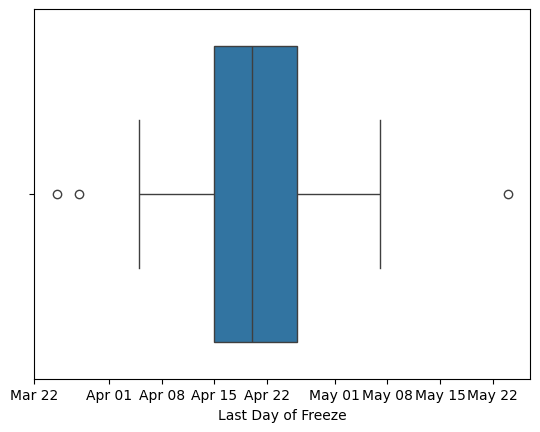

In [163]:
import seaborn as sns
from datetime import datetime as dt

# we a date column for plotting
date = pd.to_datetime(dict(year=2000, month=last_day_of_freeze["MONTH"], day=last_day_of_freeze["DAY"]))
g = sns.boxplot(x=date)
xlabels = [dt.strptime(x.get_text(), "%Y-%m-%d").strftime("%b %d") for x in g.get_xticklabels()]
g.set_xticks(g.get_xticks(), labels=xlabels)
_ = g.set_xlabel("Last Day of Freeze")

There is an interesting outlier where the last freeze occured at the end of May.
Traditionally, some time towards the end of may is the safe date for planting outside (Eisheiligen, Kalte Sophie), since no freeze is expected after that date.
Let's have a look when this outlier took place.

In [160]:
last_day_of_freeze.iloc[0]  # data is still sorted from last date to first date

YEAR     2004.0
MONTH       5.0
DAY        24.0
TGK        -0.1
Name: 16399, dtype: float64

As we can see, the last freeze at end of May occured in 2004, and the air temperature was only slightly below 0°C. 

Finally, let's also report the exact median date, the 75% quantile and the 90% quantile.

In [172]:
print("Median:", date.mean().strftime("%b %d"))
print("75% quantile:", date.quantile(0.75).strftime("%b %d"))
print("90% quantile:", date.quantile(0.90).strftime("%b %d"))

Median: Apr 19
75% quantile: Apr 26
90% quantile: May 03
